In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.gofplots as smg
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

Export the data

In [2]:
df = pd.read_excel('main Model - Bikesharing data.xlsx')

#### Exploratory data analysis

In [3]:
df.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   season      731 non-null    int64  
 2   yr          731 non-null    int64  
 3   mnth        731 non-null    int64  
 4   holiday     731 non-null    int64  
 5   weekday     731 non-null    int64  
 6   workingday  731 non-null    int64  
 7   weathersit  731 non-null    int64  
 8   temp        731 non-null    float64
 9   atemp       731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-null    int64  
 14  cnt         731 non-null    int64  
dtypes: float64(4), int64(11)
memory usage: 85.8 KB


**Correlation**

In [14]:
correlation_matrix = df[['temp', 'atemp', 'hum', 'windspeed', 'cnt' ]].corr()
correlation_matrix

,temp,atemp,hum,windspeed,cnt
temp,1.000000,0.991702,0.126963,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.100659
windspeed,-0.157944,-0.183643,-0.248489,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,1.000000


<Axes: >

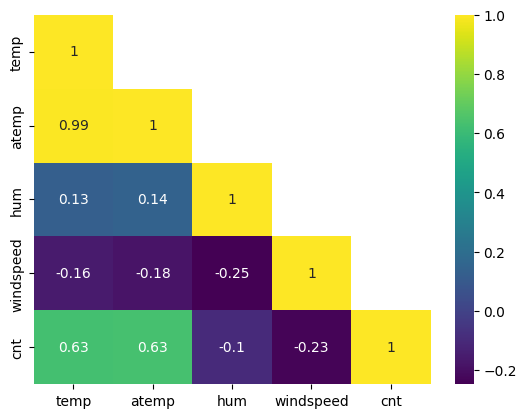

In [15]:

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='viridis', )

In [ ]:
numeric_df = df.select_dtypes(include=['number'])
numeric_df.head()

In [15]:
numeric_df.head()

,user_id,age,annual_income,purchase_amount,loyalty_score,purchase_frequency
0,1,25,45000,200,4.5,12
1,2,34,55000,350,7.0,18
2,3,45,65000,500,8.0,22
3,4,22,30000,150,3.0,10
4,5,29,47000,220,4.8,13


**VIF analysis**

In [10]:
 from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set
variable_set = df

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["variable"] = df.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(variable_set.values, i)
                          for i in range(len(variable_set.columns))]

print(vif_data)

      variable          VIF
0      instant  2206.726158
1       season    24.811676
2           yr   843.438636
3         mnth   640.345526
4      holiday     1.109992
5      weekday     3.266765
6   workingday     9.455066
7   weathersit    14.605775
8         temp   500.481280
9        atemp   579.043435
10         hum    28.226270
11   windspeed     5.513823
12      casual          inf
13  registered          inf
14         cnt          inf


C:\Users\jedre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [16]:
df[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].head()

,temp,atemp,hum,windspeed,cnt
0,0.344167,0.363625,0.805833,0.160446,985
1,0.363478,0.353739,0.696087,0.248539,801
2,0.196364,0.189405,0.437273,0.248309,1349
3,0.200000,0.212122,0.590435,0.160296,1562
4,0.226957,0.229270,0.436957,0.186900,1600


# All variables model

In [23]:
model03 = smf.ols(formula='cnt ~ atemp + hum + windspeed', data=df)

In [24]:
results03= model03.fit()
print(results03.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     209.1
Date:                Tue, 15 Oct 2024   Prob (F-statistic):           8.99e-98
Time:                        11:18:20   Log-Likelihood:                -6342.3
No. Observations:                 731   AIC:                         1.269e+04
Df Residuals:                     727   BIC:                         1.271e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3773.9591    342.867     11.007      0.0

In [21]:
p_values = results03.pvalues
z_scores = results03.tvalues 
coefficients = results03.params

summary_table = pd.DataFrame({
    'Variable': z_scores.index,
    'P-Value': p_values,
    'Z-Score': z_scores.abs(),
    'Coefficient': coefficients
})

# variables with p-values higher than 0.05 (insignificant variables)
signif_summary_table = summary_table[summary_table['P-Value'] <= 0.05]

# Sort the values (abs value)
signif_summary_table['Abs. Z-Score'] = signif_summary_table['Z-Score'].abs()
sorted_summary_table = signif_summary_table.sort_values(by='Abs. Z-Score', ascending=False)

# sorted values - table
sorted_summary_table[['Abs. Z-Score', 'Coefficient']]

C:\Users\jedre\AppData\Local\Temp\ipykernel_5612\1295243299.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signif_summary_table['Abs. Z-Score'] = signif_summary_table['Z-Score'].abs()


,Abs. Z-Score,Coefficient
Intercept,10.862375,3860.368453
hum,8.200929,-3149.109752
windspeed,6.280359,-4528.674829
atemp,1.994241,5139.152443


**Making predictions with the model equation**

In [37]:
intercept = coefficients['Intercept']
coef_1 = coefficients['hum']
coef_2 = coefficients['windspeed']
coef_3 = coefficients['atemp']


# DataFrame
PREDICTION_RESULT = pd.read_excel('Prediction dataset - Bikesharing data(1).xlsx')

PREDICTION_RESULT['predicted value'] = (
    intercept + 
    coef_1 * PREDICTION_RESULT['hum'] +
    coef_2 * PREDICTION_RESULT['windspeed'] +
    coef_3 * PREDICTION_RESULT['atemp']
)

round(PREDICTION_RESULT, 3)

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,predicted value
0,1,1,0,2,0,3,1,2,0.260,0.254,0.775,0.264,1529.018
1,2,1,0,2,0,4,1,1,0.187,0.178,0.438,0.278,2137.900
2,3,1,0,2,0,5,1,2,0.211,0.229,0.585,0.128,2613.258
3,4,1,0,2,0,6,0,2,0.233,0.243,0.929,0.161,1453.957
4,5,1,0,2,0,0,0,1,0.286,0.292,0.568,0.142,2927.401


Residuals

In [25]:
residuals03 = results03.resid

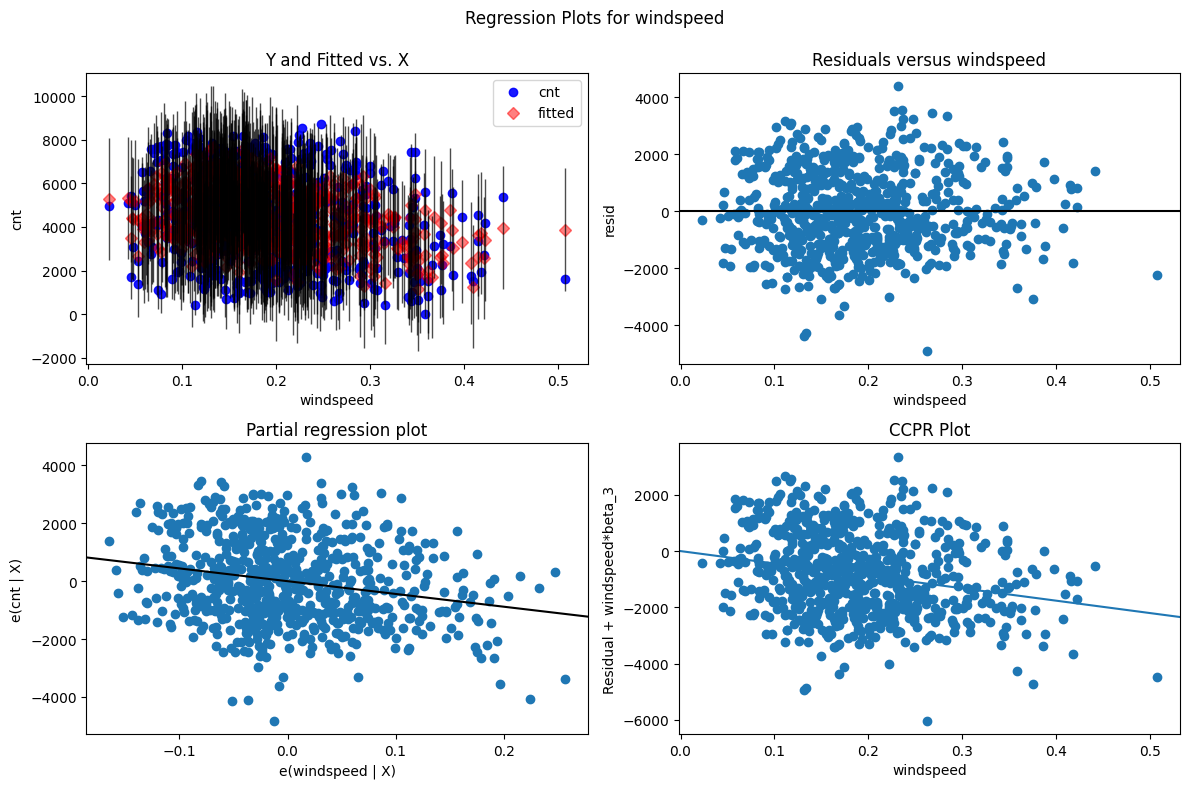

In [31]:
fig = plt.figure(figsize=(12,8))

#create regression plots
fig = sm.graphics.plot_regress_exog(results03, 'windspeed', fig=fig) 

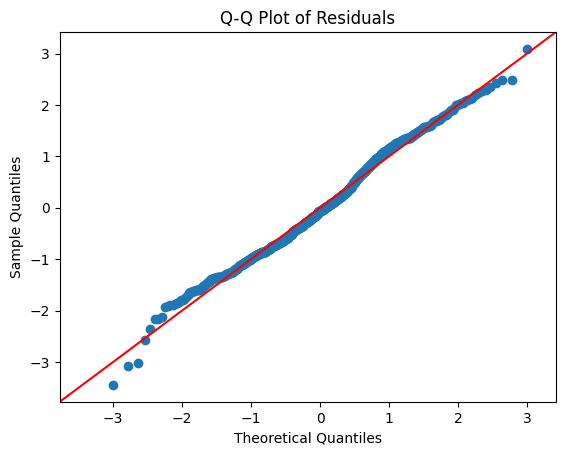

In [33]:
sm.qqplot(residuals03, dist = stats.norm, fit=True, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

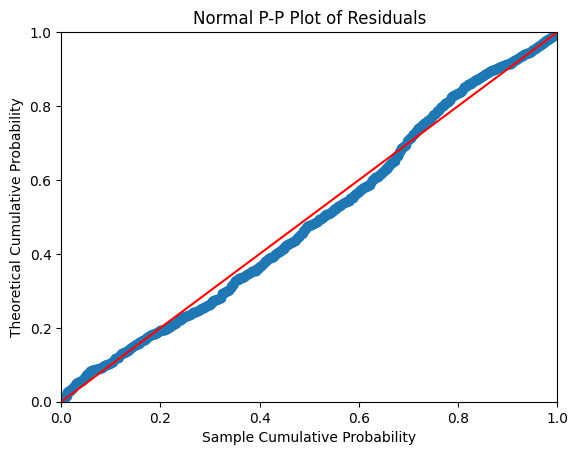

In [34]:
pplot = smg.ProbPlot(residuals03, dist = stats.norm, fit=True)
fig = pplot.ppplot(line='45')
plt.title("Normal P-P Plot of Residuals")
plt.xlabel("Sample Cumulative Probability")
plt.ylabel("Theoretical Cumulative Probability")
plt.show()

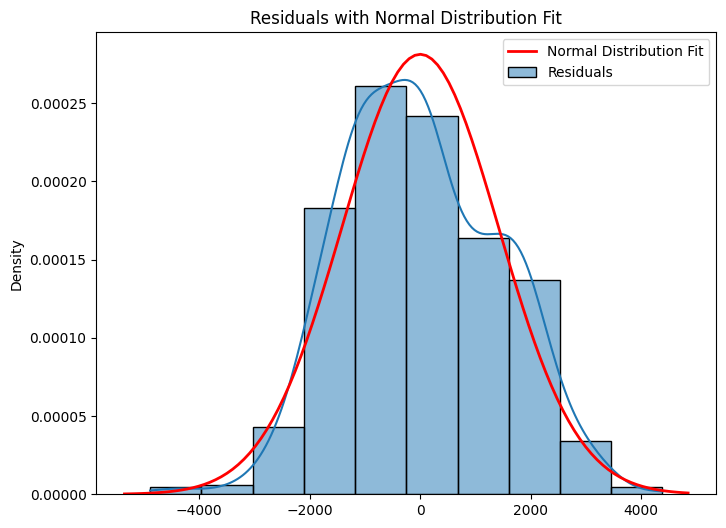

In [35]:

plt.figure(figsize=(8, 6))


sns.histplot(residuals03, bins=10, kde=True, label='Residuals', stat='density')

mu, std = stats.norm.fit(residuals03)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, color='red', linewidth=2, label='Normal Distribution Fit')

plt.legend()
plt.title("Residuals with Normal Distribution Fit")

plt.show()


# 1 variable model

In [60]:
model01 = smf.ols(formula = ' ~ ', data=df)
results01 = model01.fit()

In [61]:
print(results01.summary())

                            OLS Regression Results                            
Dep. Variable:        purchase_amount   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 1.820e+04
Date:                Sat, 12 Oct 2024   Prob (F-statistic):          2.37e-225
Time:                        11:22:50   Log-Likelihood:                -994.78
No. Observations:                 238   AIC:                             1994.
Df Residuals:                     236   BIC:                             2001.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -178.1523      4

**Excluding the high p-value variables and sorting them based on their significance**

In [62]:
p_values = results01.pvalues
z_scores = results01.tvalues 
coefficients = results01.params

summary_table = pd.DataFrame({
    'Variable': z_scores.index,
    'P-Value': p_values,
    'Z-Score': z_scores.abs(),
    'Coefficient': coefficients
})

# variables with p-values higher than 0.05 (insignificant variables)
filtered_summary_table = summary_table[summary_table['P-Value'] <= 0.05]

# Sort the values (abs value)
filtered_summary_table['Abs. Z-Score'] = filtered_summary_table['Z-Score'].abs()
sorted_summary_table = filtered_summary_table.sort_values(by='Abs. Z-Score', ascending=False)

# sorted values - table
sorted_summary_table[['Abs. Z-Score', 'Coefficient']]

,Abs. Z-Score,Coefficient
purchase_frequency,134.903986,30.496659
Intercept,38.792137,-178.152334


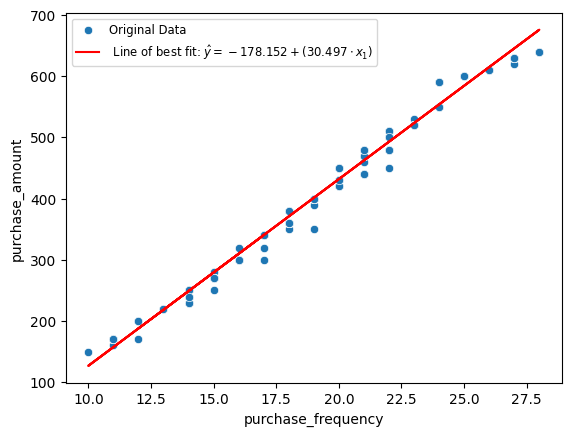

In [65]:
sns.scatterplot(x='', y='', data=df, label='Original Data')

# Plot the regression line
plt.plot(df['x'], results01.fittedvalues, color='red')

intercept = results01.params.iloc[0]
coef = results01.params.iloc[1]

equation = fr" Line of best fit: $\hat{{y}} = {intercept:.3f} + ({coef:.3f} \cdot x_1)$"


plt.plot(df['x'], results01.fittedvalues, color='red', label=equation)


plt.legend(fontsize='small')
plt.show()

In [66]:
import math
import warnings

#print the equation:
from IPython.display import display, Math
display(Math(f"$Line~of~best~fit: \hat{{y}} = {intercept:.3f} + ({coef:.3f} \cdot x_1)"))

<IPython.core.display.Math object>

1 variable prediction

In [67]:

Indep_variable_value = 

prediction = intercept + coef * Indep_variable_value
print("Predicted value is", (round(prediction, 3)))

Predicted value is 187.808


**Residuals**

In [68]:
residuals01 = results01.resid

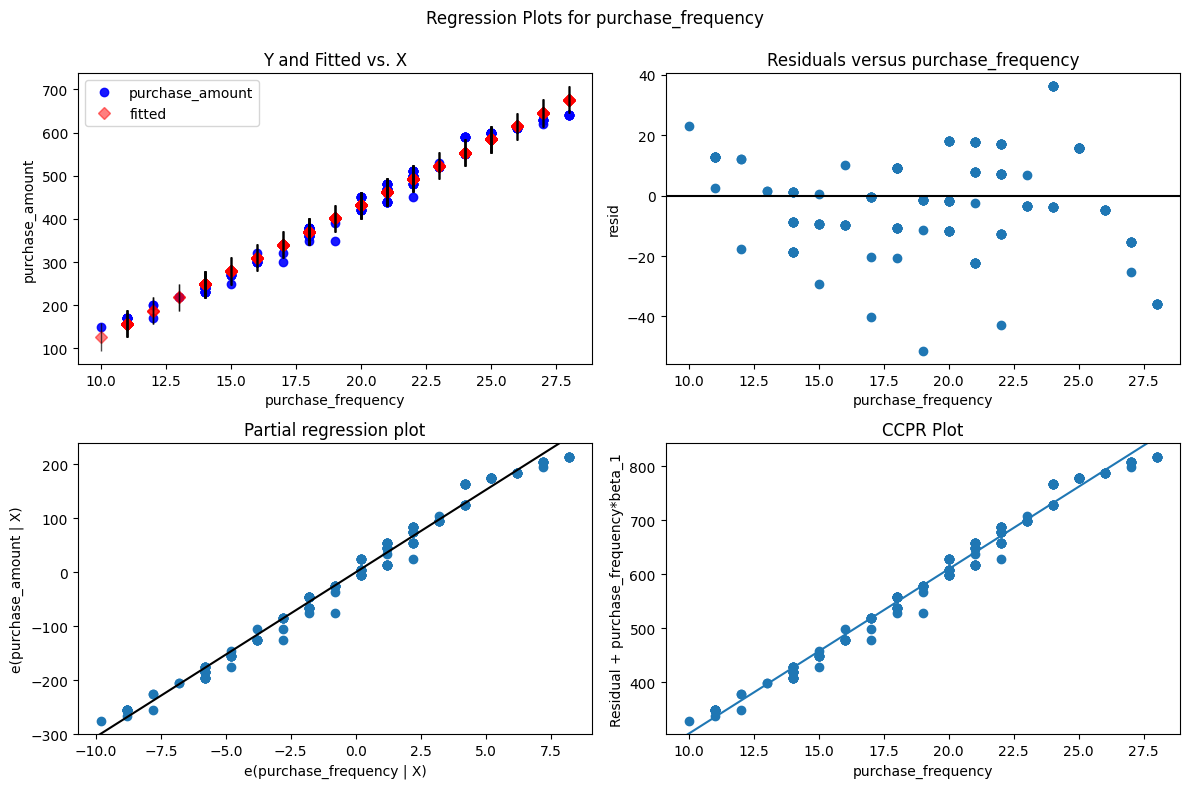

In [70]:
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(results01, 'x', fig=fig)

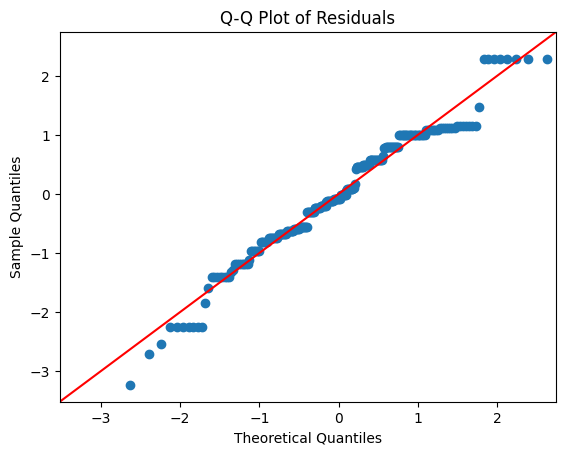

In [71]:
sm.qqplot(residuals01, dist = stats.norm, fit=True,line='45')
plt.title("Q-Q Plot of Residuals")
plt.show()

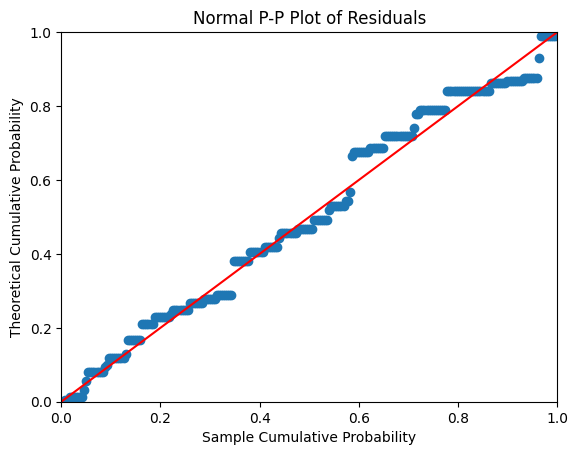

In [72]:
pplot = smg.ProbPlot(residuals01, dist=stats.norm, fit=True)
fig = pplot.ppplot(line='45')
plt.title("Normal P-P Plot of Residuals")
plt.xlabel("Sample Cumulative Probability")
plt.ylabel("Theoretical Cumulative Probability")
plt.show()

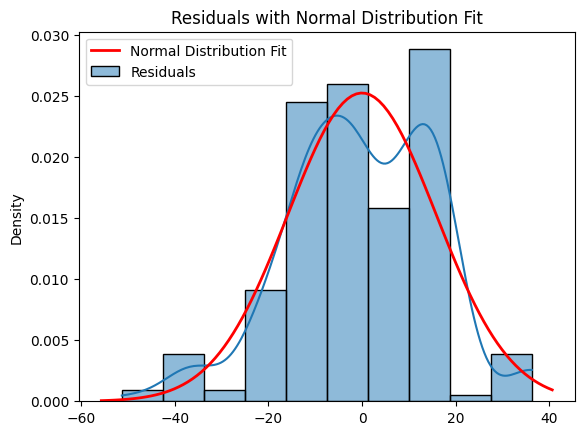

In [78]:
# Plot histogram and KDE
sns.histplot(residuals01, bins=10, kde=True, label='Residuals', stat='density')

mu, std = stats.norm.fit(residuals01)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, color='red', linewidth=2, label='Normal Distribution Fit')

plt.legend()
plt.title('Residuals with Normal Distribution Fit')
plt.show()


In [79]:
print(mu, ' ', std)

-2.9269583955428667e-13   15.81279446398651


# 2 variable model

In [80]:
numeric_df.head()

,user_id,age,annual_income,purchase_amount,loyalty_score,purchase_frequency
0,1,25,45000,200,4.5,12
1,2,34,55000,350,7.0,18
2,3,45,65000,500,8.0,22
3,4,22,30000,150,3.0,10
4,5,29,47000,220,4.8,13


In [81]:
model02 = smf.ols(formula='y ~  +  ', data=df)

In [82]:
results02 = model02.fit()
print(results02.summary())

                            OLS Regression Results                            
Dep. Variable:        purchase_amount   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.276e+04
Date:                Sat, 12 Oct 2024   Prob (F-statistic):          2.16e-240
Time:                        11:26:27   Log-Likelihood:                -954.51
No. Observations:                 238   AIC:                             1915.
Df Residuals:                     235   BIC:                             1925.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -173.0285      3

**Excluding the high p-value variables and sorting them based on their significance**

In [83]:
p_values = results02.pvalues
z_scores = results02.tvalues 
coefficients = results02.params

summary_table = pd.DataFrame({
    'Variable': z_scores.index,
    'P-Value': p_values,
    'Z-Score': z_scores.abs(),
    'Coefficient': coefficients
})

# variables with p-values higher than 0.05 (insignificant variables)
filtered_summary_table = summary_table[summary_table['P-Value'] <= 0.05]

# Sort the values (abs value)
filtered_summary_table['Abs. Z-Score'] = filtered_summary_table['Z-Score'].abs()
sorted_summary_table = filtered_summary_table.sort_values(by='Abs. Z-Score', ascending=False)

# sorted values - table
sorted_summary_table[['Abs. Z-Score', 'Coefficient']]

,Abs. Z-Score,Coefficient
Intercept,44.124313,-173.028521
purchase_frequency,21.767618,21.204639
age,9.728102,4.624066


**Comparison between 2 models:**

1 variable model is below

In [84]:
print(results01.summary())

                            OLS Regression Results                            
Dep. Variable:        purchase_amount   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 1.820e+04
Date:                Sat, 12 Oct 2024   Prob (F-statistic):          2.37e-225
Time:                        11:26:48   Log-Likelihood:                -994.78
No. Observations:                 238   AIC:                             1994.
Df Residuals:                     236   BIC:                             2001.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -178.1523      4

### Residuals for 2-variable regression

In [85]:
residuals02 = results02.resid

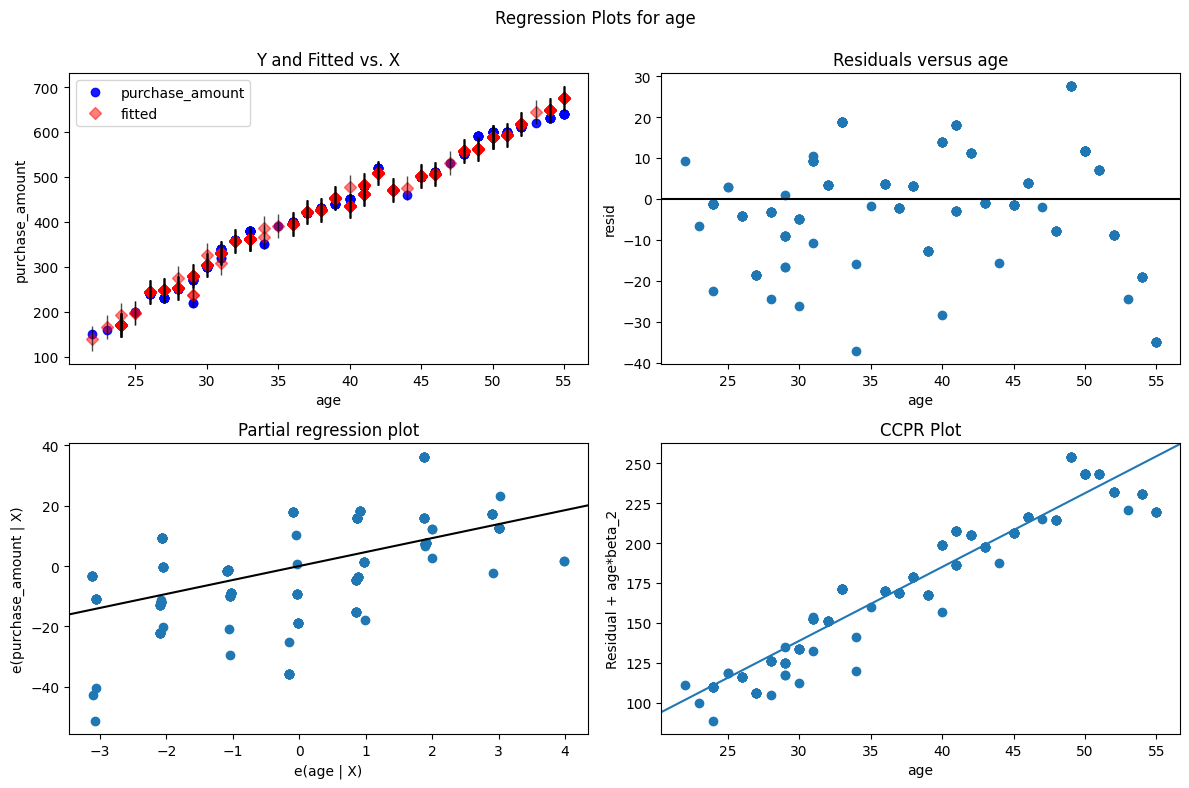

In [90]:
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(results02, 'x', fig=fig) 

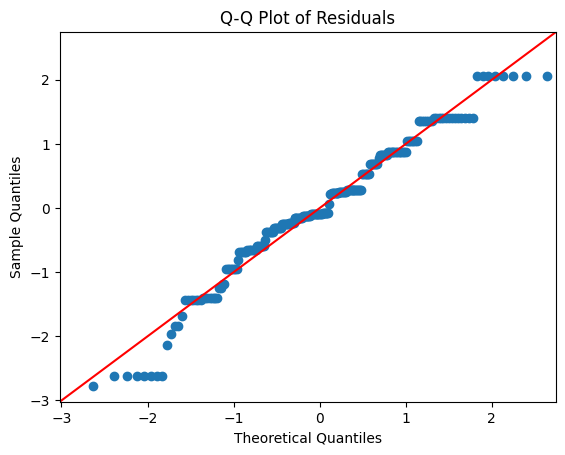

In [91]:
sm.qqplot(residuals02, dist = stats.norm, fit=True, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

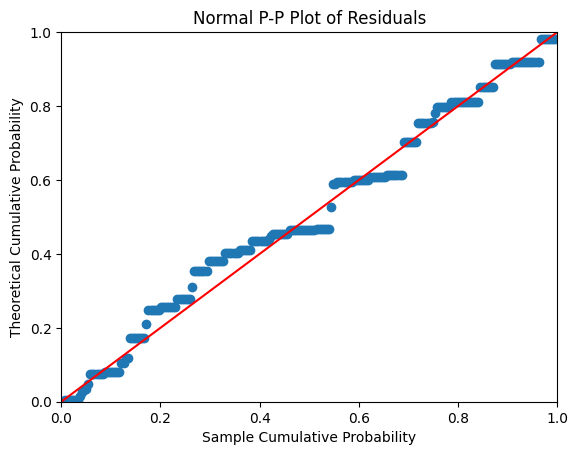

In [92]:
pplot = smg.ProbPlot(residuals02, dist = stats.norm, fit=True)
fig = pplot.ppplot(line='45')
plt.title("Normal P-P Plot of Residuals")
plt.xlabel("Sample Cumulative Probability")
plt.ylabel("Theoretical Cumulative Probability")
plt.show()

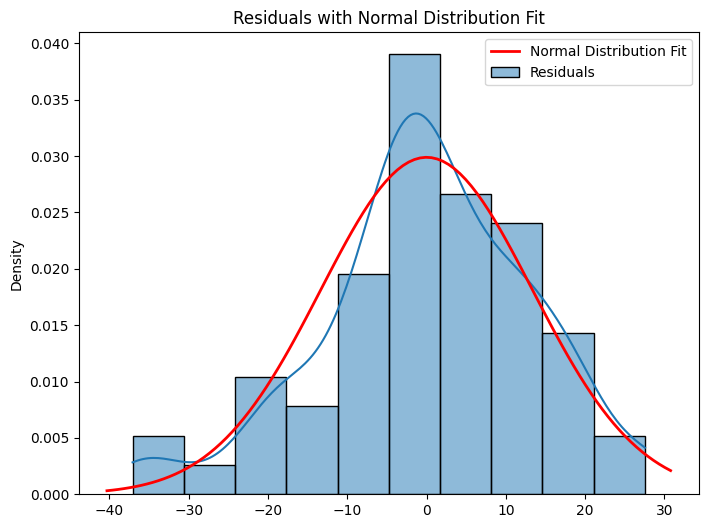

In [93]:

plt.figure(figsize=(8, 6))


sns.histplot(residuals02, bins=10, kde=True, label='Residuals', stat='density')

mu, std = stats.norm.fit(residuals02)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, color='red', linewidth=2, label='Normal Distribution Fit')

plt.legend()
plt.title("Residuals with Normal Distribution Fit")

plt.show()


In [113]:
print("mu=", mu, ' ', "std=",std)

mu= 5.5410391494569156e-14   std= 13.351352277067258
